<a href="https://colab.research.google.com/github/mildredymorales/conbio/blob/main/studentlobsterworkshopdraft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lobster Analysis Tutorial:

## Abstract
In many species, sexual selection (traits that improve an individual's chance of reproducing) are key to maintaining population health and long-term evolutionary potential.

In lobsters, males grow disproportionately large claws, a trait thought to signal fitness to potential mates. But in heavily fished populations, these large-clawed males are often targeted and removed, which may erode these important traits over time.

This tutorial walks through an analysis of Marine protected areas (MPAs) impact on lobster claws inspired by:
Sørdalen, Tonje Knutsen, et al. “Marine Protected Areas Rescue a Sexually Selected Trait in European Lobster.” Evolutionary Applications, vol. 13, no. 9, 22 May 2020, pp. 2222–2233, https://doi.org/10.1111/eva.12992.

It has publicly available data located [here](https://doi.org/10.5061/dryad.m37pvmczq).

## Workshop Goals
For this workshop, I want to:

1. Recreate 2 figures from the paper
2. Develop an improved visual representation

## Biological and Conservation Context

Human activities such as hunting and fishing can strongly influence evolution by selectively removing individuals with specific traits, often opposing natural and sexual selection. This is especially evident when large individuals, typically favored in reproduction, are disproportionately harvested. Such practices can lead to evolutionary changes like smaller body or ornament size and even loss of traits like tusks in elephants.

Sexual selection, which favors traits that signal genetic fitness, plays a key role in population health and adaptation. Removing individuals with prominent secondary sexual traits can reduce population fitness and increase extinction risk. MPAs and nature reserves can help counteract these pressures by preserving individuals unaffected by selective harvest.

In European lobsters, male claw size, a sexually selected trait, correlates with mating success but also with vulnerability to fishing. Inside MPAs, males show larger relative claw sizes than in fished areas, suggesting MPAs help preserve traits under sexual selection. This study highlights MPAs as valuable tools in conserving sexually selected traits and supporting population resilience.

## Original Relevant Figures in Paper

![](https://onlinelibrary.wiley.com/cms/asset/6872fc20-9aa3-439f-b765-366737cecfc5/eva12992-fig-0001-m.png)

Study species. European lobster (Homarus gammarus) (male) showing positions of measurement: body size; total length (TL); claw size; and crusher claw width (CW)

![](https://onlinelibrary.wiley.com/cms/asset/e6c3db2c-f855-4129-836c-63beb51319ff/eva12992-fig-0002-m.png)

Sampling location. From top, (a) red circles show the location of study areas in three counties on the Norwegian Skagerrak coast and reads from left to right; (b) Aust-Agder, (c) Vestfold and (d) Østfold. The lobster MPAs are represented by solid blue lines and fished control areas by broken red lines


![](https://onlinelibrary.wiley.com/cms/asset/06f4ad7b-8d33-407c-817d-1bb668c2e4e0/eva12992-fig-0004-m.jpg)

Claw sizes. Regression of claw size (claw width, CW, in mm) to body size (total length, TL, in mm) in female and male European lobster, sampled in lobster marine protected areas and fished areas of Aust-Agder, Vestfold and Østfold in 2017–2019. The areas in grey are 95% confidence intervals. Number of observations N = 1,426

![](https://onlinelibrary.wiley.com/cms/asset/a6d82bc5-e27e-4e05-8511-134f2fd9532d/eva12992-fig-0005-m.jpg)

Marine protected area (MPA) effect on male claw size. The curves indicate the percentage difference in predicted male claw size (claw width, CW, in mm) in MPA relative to fished area in Vestfold County (see Table 2 for model summary). The upper limit of the curve corresponds to the largest male caught in fished area (362 mm total length, TL). Dashed line is where the claw size of males in MPA and fished area are of equal size, which is only at the minimum size limit (the MPA effect occur after 250 mm TL)

# Let's Recreate!

## Step 1: Load the Dataset
We begin by importing the dataset used in the paper and ncessary packages.

Since the dataset is in a text file format and uses a tab-separated format (TSV), we need to  specify the separator as '\t'. The text file may also contain characters that are not in the default encoding format, so we'll use the 'latin-1' encoding to properly read it. Usually if your dataset is European, you'll likely need to use this encoding rather than the usualy UTF-8 because of accented letters or non-ASCII characters they have in their language.



```python
# Importing necessary libraries for data manipulation, plotting, and statistics
import pandas as pd  # Data manipulation
import seaborn as sns  # Statistical data visualization
import matplotlib.pyplot as plt  # Plotting
from matplotlib.offsetbox import OffsetImage, AnnotationBbox # for displaying images at a specific spot
from scipy.stats import ttest_ind  # Statistical test
import statsmodels.formula.api as smf  # Statistical modeling
import plotly.graph_objects as go # To create interactive and dynamic charts and graphs
```

```python
# Load the research paper publicly available data
data_path = "/content/Sørdalen_et_al.(2020)ClawData.txt"
lobster_data = pd.read_csv(data_path,  sep='\t', encoding='latin-1')
```

## Dataset Overview

It's always great practice to check your dataset after loading it in to examine it! There are many ways to do this: head, info, describe, etc. Let's just check our the first couple of rows to get a sense of everything this dataset measured.

```python
# Preview the data to ensure it loaded correctly
print("Data head:\n", lobster_data.head())
```

The dataset contains several variables related to individual lobsters, including measurements of their claws, body size, and whether they were sampled in an MPA or a fished area. Here's a description of some variables:


- TotalLength(TL): The total body length of the lobster, measured in millimeters.
- CrusherClawWidth(CW): The width of the lobster's crusher claw, measured in millimeters.
- CrusherLoss: A binary indicator of whether the lobster had lost part of its crusher claw.
- SiccorLoss: A binary indicator of whether the lobster had lost part of its scissors claw.
- ClawRatio: The ratio of the width of the crusher claw to the total body length (ClawWidth/TotalLength).


### What variable(s) seems most relevant for the paper's findings and figure?

## Step 2: Data Cleaning and Manipulation

### Clean Variable Names

Take a look at the variable names, they are long with parenthesis in some of them. That can make analysis more complicated than it needs to be, so let's change that!



```python
# Rename for easier column access
lobster_data = lobster_data.rename(columns={ # Pass a dict
    'TotalLength(TL)': 'TL',      # keys are old col names
    'CrusherClawWidth(CW)': 'CW', # values are new column names
    'CrusherLoss': 'CL',  # you can use inplace or just reassign the same df

})
lobster_data.columns
```



From the figure captions, can you imagine any data manipulation steps we need to do?

### Filter for Legally Harvestable Lobsters

In Norwegian fisheries, lobsters below 250 mm TL are legally protected from harvesting. Because fishing pressure—and thus evolutionary selection—primarily affects legal-sized individuals, we restrict our analysis to lobsters ≥ 250 mm TL. This subset better represents the population exposed to human selection and is consistent with the logic in the original paper (refer to the second figure description).


Hint: Check back above at the column names to figure out the one we need to use here! Remember how to extract a column and filter on a #, while also saving it as a **new** df called l**obster_legal**!

```python
# filter for lobsters' total length to be atleast the legal limit
lobster_legal =
# check out new df
lobster_legal
```

We can also check whether this had any effect by comparing the # of observations between datasets!

```python
# Print the # of obs of both dfs
print("legal lobster df # of obs:\n",lobster_legal.count())
print()
print("original lobster df # of obs\n", lobster_data.count())
```

We can clearly see our new dataset that is filtered by legal size has **X** observations; in contrast, our original dataset has **X** observations. We have almost **X** less!

## Summary:
We cleaned the dataset through examining na's, filtering by size, and renaming columns. We can now move on to replicating the figures!

# Part I: Regression of Claw Size Analysis

The central ecological question in the Sørdalen et al. (2020) paper is whether Marine Protected Areas (MPAs) help preserve sexually selected traits. Specifically, the large crusher claws in male European lobsters. This question arises because large claws are an important trait in mate competition and dominance displays, which are critical in lobster mating success.

However, in heavily fished populations, these large individuals are often selectively removed due to fishing pressure. Fishing practices disproportionately target larger, dominant males (because they are prized for their size), leading to selective harvesting. As a result, over time, we might see a reduction in the frequency of large claws in fished populations. In contrast, MPAs, by protecting individuals from fishing pressure, may allow these sexually selected traits to persist and potentially grow larger within the population.

In this analysis, we will investigate how claw size (specifically, the crusher claw width) scales with body size (measured by total length) across both fished areas and MPAs. By comparing how claw size varies with body size, we can determine whether the relationship between these traits differs between fished and protected areas. We will begin by performing a linear regression to quantify this relationship.


## Step 1: Data Cleaning and Filtering

From looking at the figure and its caption, what steps should we take?



### Why Remove Regenerated Claws?

Lobsters can regenerate lost claws over time, but these regenerated claws may not be as strong or effective in mate competition. When examining sexually selected traits like claw size, it’s important to focus on intact claws that haven’t been regenerated, as these are more likely to represent the true fitness of the individual. Regenerated claws could distort our analysis because they might not provide an accurate measure of the traits that are under sexual selection, leading to potential bias in our results. For this reason, we will exclude lobsters that have lost or regenerated claws from the dataset.

Hint: Look back at the variables and think about which one relates to losing the claw we care about.
Then find out the types of entries it can have to filter only lobsters that haven't lost a claw!
We want to make this a **new** df called **lobster_claws**. Remember which df we want to copy from!

```python
# Filter for only intact crusher claws
lobster_claws =
# check out the new df
lobster_claws
```

In [54]:
# Filter for only intact crusher claws
lobster_clean = lobster_legal[lobster_legal['CL'] == 0]
# check out the new df
lobster_clean

,Number,Year,Date,County,Area,Status,Sex,TL,CW,CL,SiccorLoss,ClawRatio
0,1,2017,29/08/2017,Aust-Agder,Flodevigen,MPA,Males,345,80,0,0,0.231884
1,2,2017,29/08/2017,Aust-Agder,Flodevigen,MPA,Males,250,48,0,0,0.192000
2,3,2017,29/08/2017,Aust-Agder,Flodevigen,MPA,Females,272,43,0,0,0.158088
4,5,2017,29/08/2017,Aust-Agder,Flodevigen,MPA,Males,315,75,0,0,0.238095
5,6,2017,29/08/2017,Aust-Agder,Flodevigen,MPA,Females,253,43,0,0,0.169960
...,...,...,...,...,...,...,...,...,...,...,...,...
2553,2554,2019,23/08/2019,Vestfold,Haneflu,MPA,Males,313,63,0,0,0.201278
2554,2555,2019,23/08/2019,Vestfold,Haneflu,MPA,Males,270,48,0,0,0.177778
2555,2556,2019,23/08/2019,Vestfold,Haneflu,MPA,Males,348,89,0,0,0.255747
2556,2557,2019,23/08/2019,Vestfold,Haneflu,MPA,Females,269,43,0,0,0.159851


### Why Separate by Sex?
Sexual selection often operates differently in males and females, and that’s especially true in lobsters. In this species, males are the ones who use large claws in dominance displays and mating competition, making them the focus when studying sexually selected traits. However, we also include females in this analysis for comparison, as they may exhibit different patterns or constraints on claw growth.


Hint: Here make two separate dfs based on the sex named **males** & **females**! Remember filtering strings are case sensitive!

```python
# Separate male and female datasets
males =

females =
```

### Why Restrict to the Overlapping Size Range?

To ensure a fair comparison between fished areas and MPAs, we need to focus on lobsters that fall within the same body size range. If we didn’t do this, we could be comparing populations with inherently different size distributions, which could lead to biased comparisons. For example, if one area has mostly small lobsters and another has mostly large ones, any differences in claw size might be a consequence of body size rather than the effects of the MPA. By restricting our analysis to the overlapping size range between the two areas, we can ensure that our comparison is meaningful and that we are testing the impact of the MPA on claw size, not body size.

The male size range should go upto 362 mm.

The female size range should go upto 355 mm.

Keep calling the df males and females!

```python
# Filter TL ranges for each sex df
males =

females =
```

## Step 2: Define Regression Model

To match the paper's analysis we define the regression model that will predict claw width, which includes: total length (TL), protection status (MPA vs. fished), county, and the interaction between TL and protection status. We include the interaction term only if it is statistically significant (p < 0.05), which we determine by fitting the full model and checking the p-value of the interaction term. If it is not significant, we drop the interaction to avoid overfitting.

```python
# Function to choose final formula based on interaction significance
def get_final_formula(df):
    # define formula
    full_model = smf.ols("CW ~ TL + Status + County + TL:Status", data=df).fit()
    # check if interaction status sig
    if 'TL:Status[T.MPA]' in full_model.pvalues and full_model.pvalues['TL:Status[T.MPA]'] > 0.05:
        return "CW ~ TL + Status + County"
    else:
        return "CW ~ TL + Status + County + TL:Status"
```

## Step 3: Iteratively Remove Regenerated Claws Using Residuals

Next we want to continue filtering by iteratively identifying and removing lobsters that are likely to have regenerated claws. This is done by calculating Pearson residuals from the regression model and removing the individual with the most negative residual, under the assumption that their claw is unusually small for their size. We repeat this process until the largest negative residual is less extreme than the largest positive one.

```python
# Function to identify and remove likely regenerated claws
def conservative_claw_filter(df_sex, formula, sex_label):
    df_sex = df_sex.copy()    # make a copy of df
    df_sex = df_sex.dropna(subset=['CW', 'TL'])  # Drop missing values
    df_sex['regenerated'] = False   # create new col, set all to false
    removed = []    # store claws we remove

    # build model & get residuals
    model = smf.ols(formula, data=df_sex).fit()
    df_sex['pearson_resid'] = model.get_influence().resid_studentized_internal

    # Iteratively remove the largest negative Pearson residual
    while df_sex['pearson_resid'].min() < -df_sex['pearson_resid'].max():
        idx_to_remove = df_sex['pearson_resid'].idxmin()
        df_sex.loc[idx_to_remove, 'regenerated'] = True
        removed.append(df_sex.loc[idx_to_remove])
        df_sex = df_sex.drop(idx_to_remove)
        model = smf.ols(formula, data=df_sex).fit()
        df_sex['pearson_resid'] = model.get_influence().resid_studentized_internal
        
    # make a df with all removed to check it
    removed_df = pd.DataFrame(removed)
    print(f"{sex_label}: Removed {len(removed_df)} likely regenerated claws")
    return df_sex.drop(columns='pearson_resid'), removed_df
```

## Step 4: Fit Linear Model

Once we have removed lobsters with likely regenerated claws, we fit the final regression models for both sexes using the formulas selected earlier. These models capture how claw width scales with body size and whether that relationship differs by protection status or region.


```python
# final model for analysis
formula_m = get_final_formula(males)
formula_f = get_final_formula(females)

males_final, males_removed = conservative_claw_filter(males, formula_m, "Males")
females_final, females_removed = conservative_claw_filter(females, formula_f, "Females")

model_m = smf.ols(formula_m, data=males_final).fit()
model_f = smf.ols(formula_f, data=females_final).fit()
```
```python
# print model summaries
print("\nMale Model Summary:")
print(model_m.summary())

print("\nFemale Model Summary:")
print(model_f.summary())
```

## Original Table






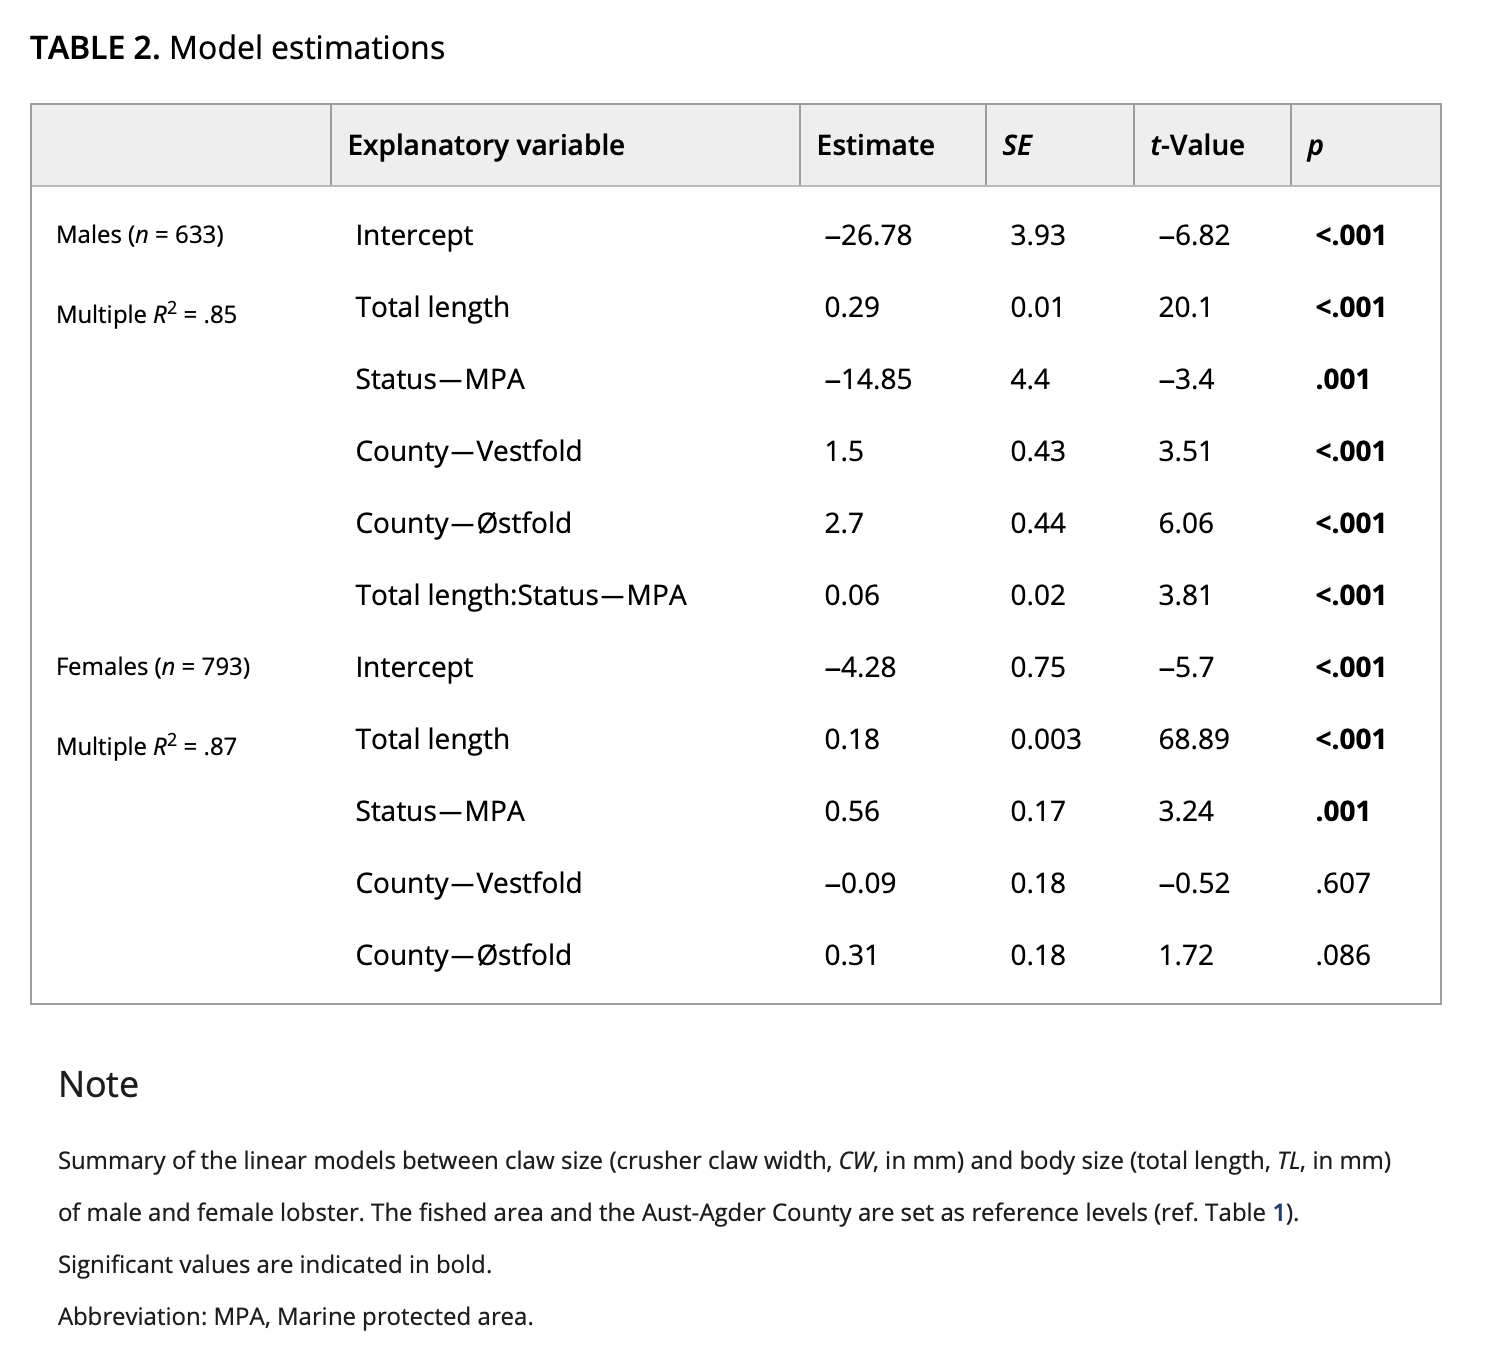

## Interpretation of Results

There are a lot of numbers! Here's a way to help you understand:

Each row is a variable (factor), and the columns tell you:

- Estimate: How much this variable changes the claw width. A positive number means it increases claw width, a negative means it decreases it.
- SE (Standard Error): How much uncertainty is in that estimate — smaller = more confident.
- t-Value: A measure of how strong the effect is compared to the noise. Bigger numbers mean stronger effects.
- p: If this number is less than 0.05 (bolded here), the effect is statistically significant — meaning it probably isn’t just random noise.

Other notes:

- R²: This model explains % of the variation in male claw size (the larger the better the fit it is)


## Step 5: Visualize the Relationship by County
To fully appreciate how this relationship varies spatially, we visualize the regression by County, and separate the plots by sex.


```python
# function to plot regression by county
def plot_regression_by_county(data, title):
    sns.set(style="whitegrid")

    # Plot with faceting by County and Sex
    g = sns.lmplot(
        data=data,
        x="TL", y="CW",
        hue="Status",
        col="County",
        row="Sex",
        height=4.5, aspect=1.2,
        scatter_kws={'s': 25, 'alpha': 0.5},
        line_kws={'linewidth': 2}
    )
    
    # set labels
    g.set_axis_labels("Total Length (TL)", "Crusher Claw Width (CW)")
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(title)
    plt.show()

# Use cleaned and labeled dataset
combined = pd.concat([
    males_final.assign(Sex="Males"),
    females_final.assign(Sex="Females")
])

plot_regression_by_county(combined, "Crusher Claw Width vs Total Length\nFaceted by County and Sex")
```

## Interpretation of Plot
### Think about...

- the slope
- the difference/similarities across counties and sex


## Summary

In this section, we explored how crusher claw width (a sexually selected trait) scales with total body length in European lobsters across fished areas and Marine Protected Areas (MPAs). We accomplished by performing linear regression, intepresting regression outputs, and visualizing regression results.

# Part III: Interactive Map Overlay of Lobster Sampling Locations
In the original Sørdalen et al. (2020) paper, the authors include a map showing sampling regions, but the geographic detail is not the best or intuitive for understanding the spatial distribution of the sampling sites.


To enhance the spatial interpretation of the data, we will create an interactive map overlay that lets us explore sampling locations more precisely. By allowing users to hover over each point and view attributes like location name, body size, and capture frequency, we add a richer spatial context to the ecological patterns we're analyzing.

To do this, there is a [related dataset](https://datadryad.org/dataset/doi:10.5061/dryad.ht76hdrft#methods) from a [follow-up study](https://pmc.ncbi.nlm.nih.gov/articles/PMC9667365/) by the same research group, which covers the same regions and includes latitude and longitude coordinates for lobster capture events. This allows us to visualize where lobsters were sampled and how variables such as body size vary across the MPA's anf fished areas.



```python
# Load the research paper publicly available data
data_path = "/content/lobstergrowth2021.txt"
lobster_map = pd.read_csv(data_path,  sep='\t', encoding='latin-1')
```



## Step 1: Load the Dataset

## Dataset Overview

Here's a description of some variables:

- timescap: How many times the lobster has been captured
- TotLG: Total lobster growth between captures in mm
- TotLcap: Total Length at capture
- Lat: Latitude of capture site
- Lon: Longitude of capture site



```python
# Preview the data to ensure it loaded correctly
print("Data head:\n", lobster_map.head())
```

Do you notice any similarities between the datasets and how we may create this map with overlayed data?


## Step 2: Data Cleaning & Manipulation
Before we can plot lobster data on a map, we need to make sure the dataset is cleaned and structured appropriately for spatial visualization.

For this visualization, we use Total Length at Capture (TotLcap) as our main biological proxy. While not a perfect measure, it gives us a quick sense of lobster body size across different sampling locations — which ties back to our original interest in the effect of MPAs on body size and sexually selected traits.

To see this measurement on an interactive map, we need to create the text that wil show when we hover over a data point.

What variables would we like to see?

```python
# Create the hover text
lobster_map['hover_text'] = (
    '<br>Total Length: ' + lobster_map['TotLcap'].astype(str)
)
```

## Step 3: Visualizing Spatial Data with folium

To create our interactive map, we’ll use the folium library, a powerful Python package that acts as a wrapper around Leaflet.js, a popular JavaScript library for interactive maps.

folium allows us to:

- Create web-based maps embedded directly in Jupyter/Colab notebooks.
- Overlay data points using latitude and longitude coordinates.
- Add interactive pop-ups or hover text to explore details about each location.
- Use different base layers, zoom levels, and marker styles to tailor the visualization.

```python
# Create the figure
fig = go.Figure()

# Loop over each 'Status' group (MPA or Fished)
for status in lobster_map['Status'].unique():    # This allows us to add separate markers and legend entries
    sub_df = lobster_map[lobster_map['Status'] == status] # Subset by status

    # Add a mapbox scatter trace for this group
    fig.add_trace(go.Scattermapbox(
        lat=sub_df['Lat'], # Latitude coordinates
        lon=sub_df['Lon'], # Longitude coordinates
        mode='markers',    # Show as points
        marker=go.scattermapbox.Marker(
            size=10,                 # Marker size
            color=sub_df['TotLcap'], # Use total length as color gradient
            colorscale='inferno_r',           # Or 'Plasma', 'Jet', 'Hot', 'Turbo', etc.
            cmin=lobster_map['TotLcap'].min(),       # Normalize color scale
            cmax=lobster_map['TotLcap'].max(),
            colorbar=dict(title='Total Length'),            # Add colorbar legend
            showscale=(status == lobster_map['Status'].unique()[0])  # Only show colorbar once
        ),
        text=sub_df['hover_text'],  # Hover label
        name=status
    ))
```
```python
# Map layout customoization
fig.update_layout(
    autosize=False,
    margin=dict(l=15, r=15, t=45, b=15),
    width=1200,
    height=800,
    hovermode='closest',  # Show closest point's info on hover
    mapbox=dict(
        style="open-street-map",
        center=dict(
            lat=lobster_map['Lat'].mean(),   # Center map by average lat
            lon=lobster_map['Lon'].mean()    # Center map by average lon
        ),
        zoom=7.5,         # Adjust zoom level when map first shows
    ),
    legend=dict(          # Adjust legend appearance
        title='Status',
        font=dict(size=14),
        itemsizing='constant',
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        bgcolor="rgba(255,255,255,0.7)",
        bordercolor="black",
        borderwidth=1
    ),
    title='Lobster Total Length by Status'
)

fig.show()
```


## Play!

What did you find?

## Summary

We created a base map centered on the coastal regions of Norway with the lobster capture locations as interactive markers, colored based on a biological variable, and it displays hover tooltips.

# Wrap Up

This tutortial has helped replicate and improve on some figures in the paper, while simulatenously building our python analysis skills and understanding MPA's effect on lobster's health!